## 物体（自動車）検知Scoring APIへのリクエスト、ボックスの重ね合わせ画像の保存

ドキュメント：https://docs.h2o.ai/h2o-hydrogen-torch/tutorials/predictions/tutorial-2b

In [56]:
import os
import base64
import json
import requests

import cv2
import pandas as pd
import numpy as np

import torch
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

In [82]:
# パラメータ

URL = 'https://model.internal.dedicated.h2o.ai/bffea6ac-818e-41bd-81d8-aba7228929e3/model/score'   # APIエンドポイント

# current directory上の元画像と結果画像のフォルダ
IMG_IN = 'images'
IMG_OUT = 'images_out'

img_path = 'sample2.jpg'    # スコアリング用画像ファイル
file_name = os.path.splitext(img_path)
img_path = os.path.join(IMG_IN, img_path)
print(img_path)

img_out_path = file_name[0] + '_box.jpg'
img_out_path = os.path.join(IMG_OUT, img_out_path)
print(img_out_path)

conf_threshold = 0.5    # バウンディングボックスのConfidence閾値

images/sample2.jpg
images_out/sample2_box.jpg


In [18]:
# スコアリング用画像の読み込み

img = cv2.imread(img_path)
print(type(img))
print(img.shape)

images/sample2.jpg
<class 'numpy.ndarray'>
(260, 400, 3)


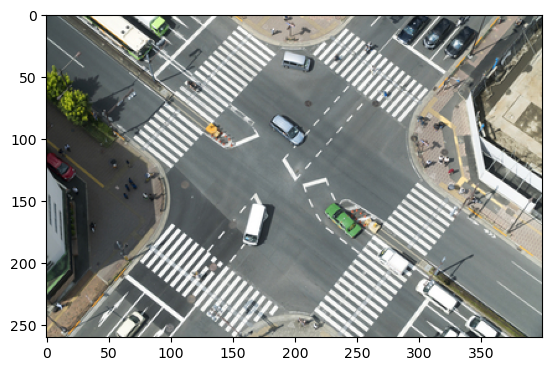

In [19]:
# 元画像を表示する場合

import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [20]:
# 画像データをbase64でエンコード
img_encode = base64.b64encode(cv2.imencode(".png", img)[1]).decode()
print(type(img_encode))
img_encode[:30]

<class 'str'>


'iVBORw0KGgoAAAANSUhEUgAAAZAAAA'

In [21]:
# APIにPOSTするjsonデータ
data = {"fields": ["input"], "rows": [[img_encode]]}

In [22]:
%%time

# APIへのPOSTリクエスト
r = requests.post(url=URL, json=data)
r

CPU times: user 53.9 ms, sys: 3.96 ms, total: 57.8 ms
Wall time: 2.73 s


<Response [200]>

In [23]:
# 取得結果の加工
ret = r.json()  
print(type(ret))
ret.keys()

<class 'dict'>


dict_keys(['fields', 'id', 'score'])

In [24]:
ret['fields']

['output']

In [25]:
ret['id']

'89e13a2c-eb98-485f-8fde-62a5cda09b42'

In [26]:
# 'boxes' : バウンディングボックス座標
# 'confidences' : Confidence. Confidenceの大きい順にソートされている
# 'classes' : 0:自動車、-1:無し

ret_json = json.loads(ret["score"][0][0])
print(ret_json.keys())
ret_json

dict_keys(['boxes', 'confidences', 'classes'])


{'boxes': [[[179.3201446533203,
    80.83551025390625,
    208.76739501953125,
    106.07918548583984],
   [225.98326110839844,
    150.8643035888672,
    260.9272155761719,
    183.51881408691406],
   [158.6365509033203,
    150.54185485839844,
    181.59368896484375,
    185.60960388183594],
   [3.5694878101348877,
    113.6467514038086,
    26.539819717407227,
    136.5044708251953],
   [336.506103515625, 242.0041046142578, 364.3064270019531, 260.0],
   [304.17498779296875,
    12.216793060302734,
    319.3304748535156,
    27.622230529785156],
   [285.3114013671875,
    7.690800666809082,
    302.4479064941406,
    20.020267486572266],
   [190.06112670898438,
    30.035131454467773,
    215.1038818359375,
    45.93407440185547],
   [275.49224853515625, 0.0, 289.6054382324219, 4.165101051330566],
   [291.2632141113281,
    2.5415284633636475,
    304.9469299316406,
    12.84625244140625],
   [292.7604675292969,
    1.0264395475387573,
    307.0399475097656,
    9.773528099060059],
 

In [27]:
pd.DataFrame({'boxes':ret_json['boxes'][0], 'confidences':ret_json['confidences'][0], 'classes':ret_json['classes'][0]})

,boxes,confidences,classes
0,"[179.3201446533203, 80.83551025390625, 208.767...",0.990725,0
1,"[225.98326110839844, 150.8643035888672, 260.92...",0.978538,0
2,"[158.6365509033203, 150.54185485839844, 181.59...",0.907595,0
3,"[3.5694878101348877, 113.6467514038086, 26.539...",0.784054,0
4,"[336.506103515625, 242.0041046142578, 364.3064...",0.739959,0
...,...,...,...
95,"[0.0, 0.0, 0.0, 0.0]",0.000000,-1
96,"[0.0, 0.0, 0.0, 0.0]",0.000000,-1
97,"[0.0, 0.0, 0.0, 0.0]",0.000000,-1
98,"[0.0, 0.0, 0.0, 0.0]",0.000000,-1


In [83]:
print(conf_threshold)

conf = np.array(ret_json['confidences'][0] )[np.array(ret_json['confidences'][0] ) >= conf_threshold]   # conf_threshold以上のConfidence
b_boxes = np.array(ret_json['boxes'][0])[np.array(ret_json['confidences'][0] ) >= conf_threshold]   # conf_threshold以上のボックス
count = len(conf)  # ボックスの数

0.5


In [84]:
img_t = read_image(img_path)     # torch.Tensorとして画像を読み込む
print(type(img_t))
img_t.size()

<class 'torch.Tensor'>


torch.Size([3, 260, 400])

In [85]:
# 画像とボックスの重ね合わせ
img_with_box = draw_bounding_boxes(
    image=img_t,
    boxes=torch.from_numpy(b_boxes), 
    #labels=[str(i) for i in conf],   # Confidenceをラベルとする場合
    colors="red",
)
print(img_with_box.shape)

img_with_box = to_pil_image(img_with_box)    # PIL imageへ変換

torch.Size([3, 260, 400])


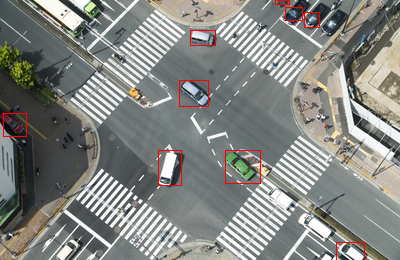

ボックスの数：9


In [86]:
display(img_with_box)
print('ボックスの数：{}'.format(count))

In [87]:
# 画像の保存
img_with_box.save(img_out_path)